#### This notebook creates figures for our paper.

Load libraries

In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the knee single-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
f = 'file1002428_v2.h5'
file_name = '/gscratch/fellows/fastmri/80x80/singlecoil_test/' + f
hf = h5py.File(file_name)

In [3]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc']
Attrs: {'max': 0.001668671, 'norm': 0.1249997}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [4]:
# load kspace example
volume_kspace = hf['kspace'][()]
print("old k-space:", volume_kspace.shape)

if len(volume_kspace.shape) == 3: # singlecoil
    newshape = volume_kspace.shape
    newshape = list(newshape)
    newshape.insert(1, 1)
    newshape = tuple(newshape)
    volume_kspace = volume_kspace.reshape(newshape)
    print("new k-space:", volume_kspace.shape)

# load reconstruction for example
#reconstruction = hf['reconstruction_rss'][()]
reconstruction = hf['reconstruction_esc'][()]
print("reconstruction:", reconstruction.shape)

old k-space: (15, 80, 80)
new k-space: (15, 1, 80, 80)
reconstruction: (15, 80, 80)


In [5]:
slice_kspace = volume_kspace[0] # Choosing the 0-th slice of this volume so no problem with single or multi-coil

coils = [0, 5, 10] if volume_kspace.shape[1] > 1 else [0]

Let's see what the absolute value of k-space looks like:

In [6]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

(1, 80, 80)


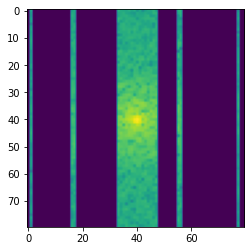

In [7]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), coils)
print(slice_kspace.shape)

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [8]:
import fastmri
from fastmri.data import transforms as T

In [9]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

In [10]:
crop_size = (reconstruction.shape[-2], reconstruction.shape[-1])
print("Crop size:", crop_size)

slices = len(volume_kspace)
slice = 10 #len(volume_kspace) // 2
print("Choosing slice", slice, "out of", slices, "slices.")

image = T.to_tensor(volume_kspace)#[slice])
image = fastmri.ifft2c(image)
image = T.complex_center_crop(image, crop_size)
image = fastmri.complex_abs(image)

# normalize input
image, mean, std = T.normalize_instance(image, eps=1e-100)
image = image.clamp(-6, 6)#.squeeze(1)
print(image.shape)

Crop size: (80, 80)
Choosing slice 10 out of 15 slices.
torch.Size([15, 1, 80, 80])


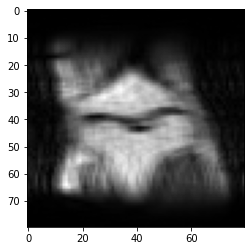

In [11]:
plt.imshow(image.squeeze(1)[slice], cmap='gray')

Visualize the layers.

In [12]:
import fastmri
from pathlib import Path

import torch
from torch.autograd import Variable
from fastmri.pl_modules import FastMriDataModule, UnetModule, UtransformerModule

from captum.attr import GuidedGradCam, GuidedBackprop
from captum.attr import LayerActivation, LayerConductance, LayerGradCam

# load the ckpt
#ckpt = torch.load('/gscratch/fellows/npho/fastmri-oms/fastmri_examples/unet/unet/unet_demo/checkpoints/epoch=20.ckpt')
ckpt_un = torch.load("/gscratch/fellows/npho/fastmri-oms/results/unet_128_48.ckpt")
ckpt_ut = torch.load("/gscratch/fellows/npho/fastmri-oms/results/utransformer_128_46.ckpt")


In [13]:
print(ckpt_un.keys())
print(ckpt_un['hyper_parameters'])

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'callbacks', 'optimizer_states', 'lr_schedulers', 'state_dict', 'hparams_name', 'hyper_parameters'])
{'in_chans': 1, 'out_chans': 1, 'chans': 128, 'num_pool_layers': 4, 'drop_prob': 0.0, 'lr': 0.001, 'lr_step_size': 40, 'lr_gamma': 0.1, 'weight_decay': 0.0}


In [14]:
# u-net
model_un = UnetModule(
    in_chans=ckpt_un['hyper_parameters']['in_chans'],
    out_chans=ckpt_un['hyper_parameters']['out_chans'],
    chans=ckpt_un['hyper_parameters']['chans'],
    num_pool_layers=ckpt_un['hyper_parameters']['num_pool_layers'],
    drop_prob=ckpt_un['hyper_parameters']['drop_prob'],
    lr=ckpt_un['hyper_parameters']['lr'],
    lr_step_size=ckpt_un['hyper_parameters']['lr_step_size'],
    lr_gamma=ckpt_un['hyper_parameters']['lr_gamma'],
    weight_decay=ckpt_un['hyper_parameters']['weight_decay'],
)

model_un.load_state_dict(ckpt_un['state_dict'])

for param in model_un.parameters():
    param.requires_grad=True

model_un.eval()
model_un.zero_grad()

In [15]:
print(model_un.unet.up_conv[-1])
print(model_un.unet.up_conv[-1][0].layers[4])

Sequential(
  (0): ConvBlock(
    (layers): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Dropout2d(p=0.0, inplace=False)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): LeakyReLU(negative_slope=0.2, inplace=True)
      (7): Dropout2d(p=0.0, inplace=False)
    )
  )
  (1): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [16]:
print(ckpt_ut.keys())
print(ckpt_ut['hyper_parameters'])

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'callbacks', 'optimizer_states', 'lr_schedulers', 'state_dict', 'hparams_name', 'hyper_parameters'])
{'in_chans': 1, 'out_chans': 1, 'chans': 128, 'num_pool_layers': 4, 'drop_prob': 0.0, 'mhsa_heads': 4, 'mhsa_dropout': 0.0, 'mhca_heads': 0, 'mhca_dropout': 0.0, 'lr': 0.001, 'lr_step_size': 40, 'lr_gamma': 0.1, 'weight_decay': 0.0}


In [17]:
# u-transformer
model_ut = UtransformerModule(
    in_chans=ckpt_ut['hyper_parameters']['in_chans'],
    out_chans=ckpt_ut['hyper_parameters']['out_chans'],
    chans=ckpt_ut['hyper_parameters']['chans'],
    num_pool_layers=ckpt_ut['hyper_parameters']['num_pool_layers'],
    drop_prob=ckpt_ut['hyper_parameters']['drop_prob'],
    mhsa_heads=ckpt_ut['hyper_parameters']['mhsa_heads'],
    mhsa_dropout=ckpt_ut['hyper_parameters']['mhsa_dropout'],
    mhca_heads=ckpt_ut['hyper_parameters']['mhca_heads'],
    mhca_dropout=ckpt_ut['hyper_parameters']['mhca_dropout'],
    lr=ckpt_ut['hyper_parameters']['lr'],
    lr_step_size=ckpt_ut['hyper_parameters']['lr_step_size'],
    lr_gamma=ckpt_ut['hyper_parameters']['lr_gamma'],
    weight_decay=ckpt_ut['hyper_parameters']['weight_decay'],
)

model_ut.load_state_dict(ckpt_ut['state_dict'])

for param in model_ut.parameters():
    param.requires_grad=True

model_ut.eval()
model_ut.zero_grad()

In [18]:
print(model_ut.transformer.up_conv[-1])
print(model_ut.transformer.up_conv[-1][0].layers[4])

Sequential(
  (0): ConvBlock(
    (layers): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Dropout2d(p=0.0, inplace=False)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): LeakyReLU(negative_slope=0.2, inplace=True)
      (7): Dropout2d(p=0.0, inplace=False)
    )
  )
  (1): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [19]:
print(reconstruction.shape)
print(image.shape)

(15, 80, 80)
torch.Size([15, 1, 80, 80])


In [20]:
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
from torch.nn import functional as F

class GradCam:
    def grad_cam(self, X, y, model, slice):
        """
        Input:
        - X: Input image (slice, coil, x, y)
        - y: Target image
        - model: A pretrained CNN that will be used to compute the gradcam.
        - slice: slice of the MRI image to visualize
        """

        x = Variable(X[slice, :, :], requires_grad=True) # (1, 80, 80)
        y = Variable(torch.tensor(y[slice, :, :]), requires_grad=False).unsqueeze(0) # (1, 80, 80)
        
        #X = Variable(X, requires_grad=True) # (1, 80, 80)
        #y = Variable(torch.tensor(y), requires_grad=False).unsqueeze(1) # (1, 80, 80)
        
        #print("X", X.shape)
        #print("y", y.shape)
        
        conv_module = None
        if type(model) is fastmri.pl_modules.unet_module.UnetModule:
            conv_module = model.unet.up_conv[-1][0].layers[4]
        else:
            conv_module = model.transformer.up_conv[-1][0].layers[4]
            
        self.gradient_value = None  # Stores gradient of the module you chose above during a backwards pass.
        self.activation_value = None  # Stores the activation of the module you chose above during a forwards pass.

        def gradient_hook(a, b, gradient):
            self.gradient_value = gradient[0]

        def activation_hook(a, b, activation):
            self.activation_value = activation

        conv_module.register_forward_hook(activation_hook)
        conv_module.register_backward_hook(gradient_hook)

        cam = []

        #N, _, _, _ = X.shape 
        #for n in range(N):
            #print("GradCAM Slice", n)
            #x = X[n, :, :, :].clone().detach()
            
        # forward pass
        output = model.forward(x) # (1, 80, 80)

        # backward pass of correct class output scores
        #target = y[n, :, :, :].clone().detach()
        #loss = F.l1_loss(output, target)
        
        loss = F.l1_loss(output, y)
        
        loss.backward()

        # average the full kernel of each channel to get alpha weights
        alpha = torch.mean(self.gradient_value, dim=[0, 2, 3]) # (1, 100, 80, 80) -> (100)

        # weight the channels by corresponding gradients
        c = alpha.reshape((1,-1,1,1)) * self.activation_value # (1, 100, 1, 1) * (1, 100, 80, 80)
        c = torch.sum(c, dim=1).squeeze() # (1, 100, 80, 80) -> (1, 80, 80) -> (80, 80)
        c = torch.nn.functional.relu(c) # only '+' influence on input for classification

        cam.append( c.detach().numpy() )

        cam = np.asarray(cam)

        # Rescale GradCam output to fit image.
        cam_scaled = []
        for i in range(cam.shape[0]):
            cam_scaled.append(np.array(Image.fromarray(cam[i]).resize(X[i, 0, :, :].shape, Image.BICUBIC)))
        cam = np.array(cam_scaled)
        cam -= np.min(cam)
        cam /= np.max(cam)
        return output, cam

In [21]:
gc = GradCam()
output1, gradcam_result1 = gc.grad_cam(image, reconstruction, model_un, slice)
gradcam_result1 = gradcam_result1.squeeze(0)
#gradcam_result = np.expand_dims(gradcam_result, axis=2)
print(gradcam_result1.shape)
print(image.shape)
print((matplotlib.cm.jet(gradcam_result1)*255).shape)

/gscratch/fellows/npho/pytorch-cuda11/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


(80, 80)
torch.Size([15, 1, 80, 80])
(80, 80, 4)


In [22]:
gc = GradCam()
output2, gradcam_result2 = gc.grad_cam(image, reconstruction, model_ut, slice)
gradcam_result2 = gradcam_result2.squeeze(0)
#gradcam_result = np.expand_dims(gradcam_result, axis=2)
print(gradcam_result2.shape)
print(image.shape)
print((matplotlib.cm.jet(gradcam_result2)*255).shape)

(80, 80)
torch.Size([15, 1, 80, 80])
(80, 80, 4)
[[0.03816021 0.07353282 0.08395622 ... 0.0953538  0.06886013 0.0639694 ]
 [0.07481121 0.09388795 0.12941319 ... 0.10982932 0.1253928  0.07211562]
 [0.07459971 0.12449598 0.13256954 ... 0.1732268  0.12693821 0.12202438]
 ...
 [0.07940174 0.11352528 0.14504816 ... 0.1393698  0.11430001 0.11227301]
 [0.07995182 0.14623062 0.16105567 ... 0.15604582 0.1340002  0.11715092]
 [0.05114676 0.07947595 0.10897002 ... 0.11060419 0.08524993 0.07890445]]


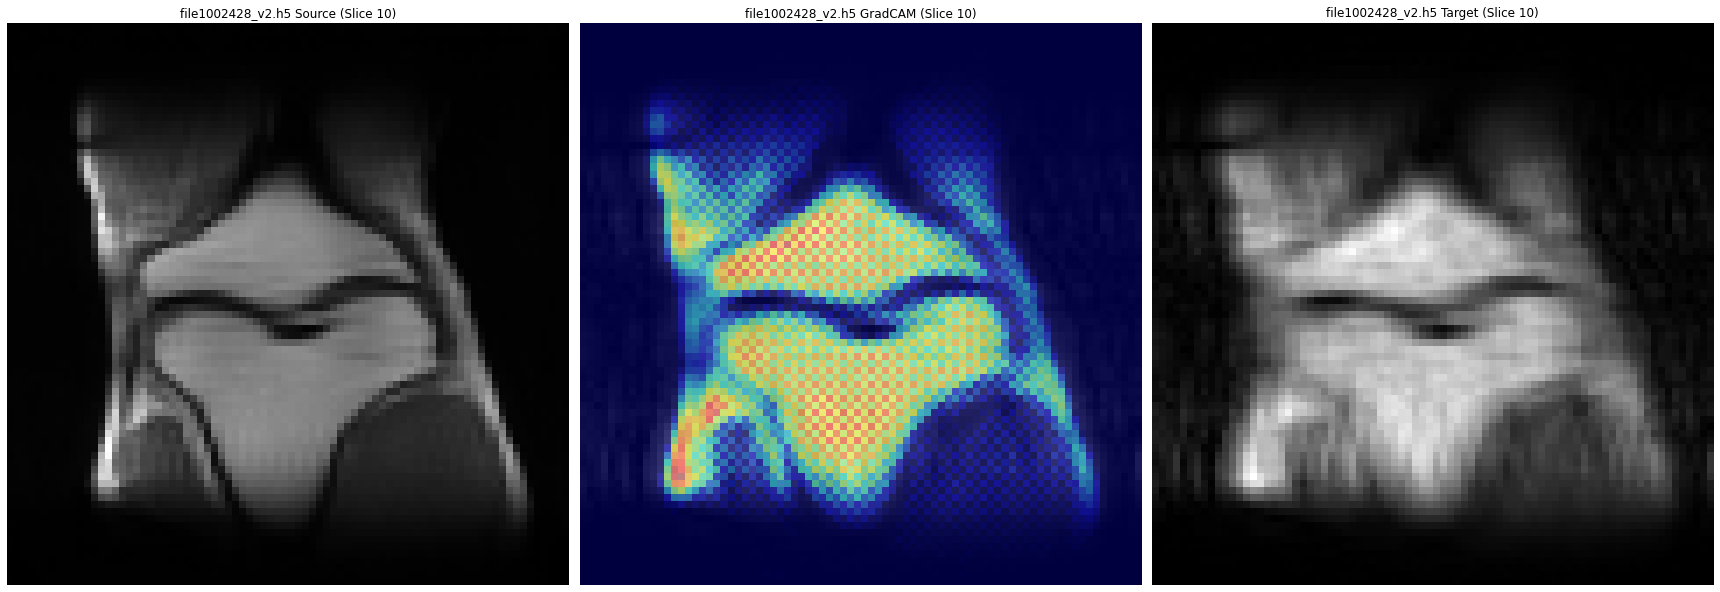

In [23]:
plt.figure(figsize=(24, 24))
X = np.expand_dims(image[slice, 0, :, :], axis=2)

s = "(Slice " + str(slice) + ")"

plt.subplot(1, 3, 1)
plt.title(f + " Source " + s)
#plt.imshow(image.squeeze(1)[slice], cmap='gray')
plt.imshow(output1.squeeze(0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.gcf().tight_layout()

plt.subplot(1, 3, 2)
plt.imshow(image.squeeze(1)[slice], cmap='gray')

focus = (matplotlib.cm.jet(gradcam_result1)[:,:,:3]*255) # (80, 80, 4)
focus -= np.min(focus)
focus /= np.max(focus)
plt.imshow(focus, interpolation='nearest', alpha=0.5)

'''
print("image", image.shape)
for i in range(gradcam_result.shape[0]):
    gradcam_val = gradcam_result[i]
    focus = np.expand_dims(image[i, 0, :, :], axis=2) + (matplotlib.cm.jet(gradcam_val)[:,:,:3]*255)
    focus -= np.min(focus)
    focus /= np.max(focus)
    plt.imshow(focus, alpha=0.50)
'''

plt.title(f + " GradCAM " + s)
plt.axis('off')
plt.gcf().tight_layout()

plt.subplot(1, 3, 3)
plt.title(f + " Target " + s)
plt.imshow(reconstruction[slice], cmap='gray')
plt.axis('off')
plt.gcf().tight_layout()


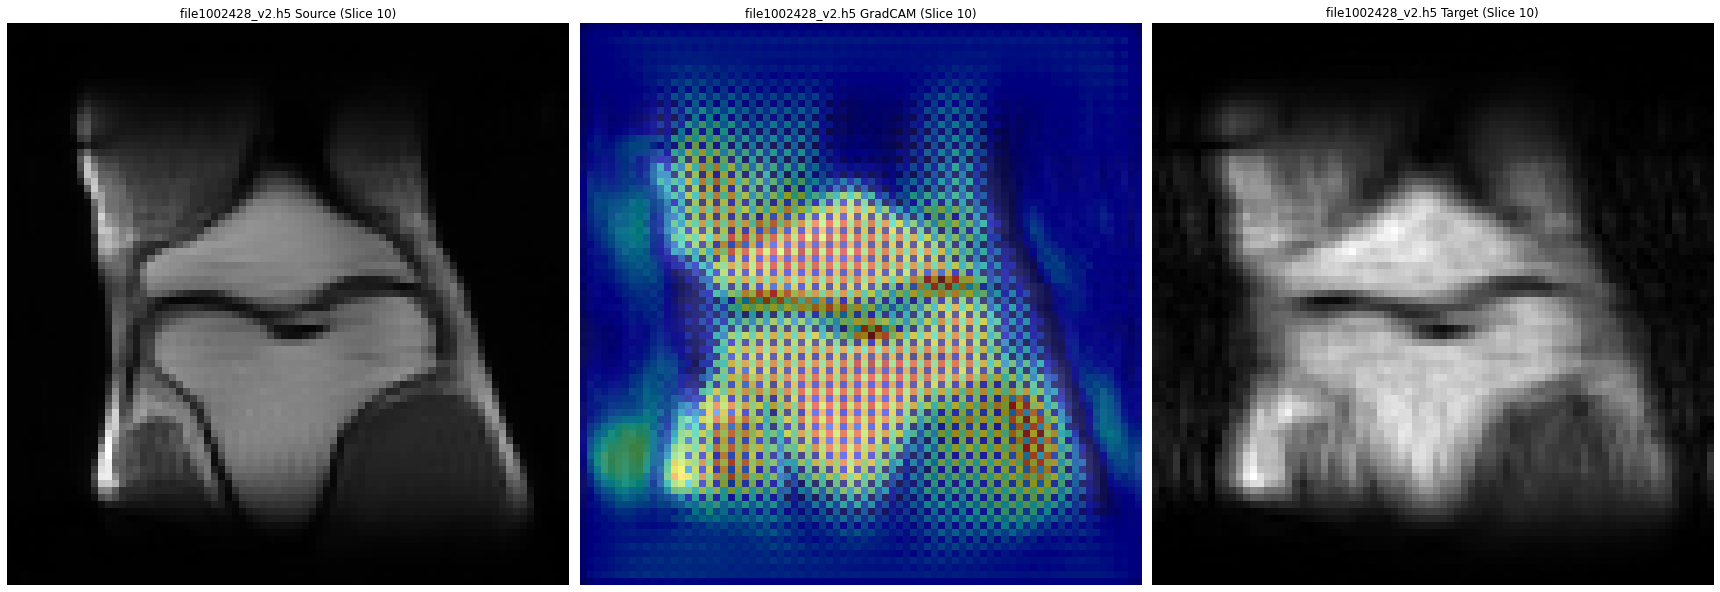

In [24]:
plt.figure(figsize=(24, 24))
X = np.expand_dims(image[slice, 0, :, :], axis=2)

s = "(Slice " + str(slice) + ")"

plt.subplot(1, 3, 1)
plt.title(f + " Source " + s)
#plt.imshow(image.squeeze(1)[slice], cmap='gray')
plt.imshow(output2.squeeze(0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.gcf().tight_layout()

plt.subplot(1, 3, 2)
plt.imshow(image.squeeze(1)[slice], cmap='gray')

focus = (matplotlib.cm.jet(gradcam_result2)[:,:,:3]*255) # (80, 80, 4)
focus -= np.min(focus)
focus /= np.max(focus)
plt.imshow(focus, interpolation='nearest', alpha=0.5)

plt.title(f + " GradCAM " + s)
plt.axis('off')
plt.gcf().tight_layout()

plt.subplot(1, 3, 3)
plt.title(f + " Target " + s)
plt.imshow(reconstruction[slice], cmap='gray')
plt.axis('off')
plt.gcf().tight_layout()